# Métodos de Ensemble - Random Forest

- Vamos passar a estudar um dos algoritmos de machine learning mais poderosos que existe, o **random forest**.
- Ele faz parte de um conjunto de métodos chamados métodos de *ensemble*, que funcionam como um grupo de preditores, que em conjunto dão resultados melhores do que cada um individualmente.
    - Exemplo: na aula passada vimos árvores de decisão. Usando o método de ensembles, podemos treinar um grupo de árvores de decisão, cada um sobre um subconjunto de treino diferente e aleatório.
- Métodos de ensemble populares: bagging, boosting e stacking.

---
No scikit learning, os métodos de ensemble estão dentro do método `sklearn.ensemble`

Vamos começar pelo "classificador votante" (Voting Classifier)


## Voting Classifier

`from sklearn.ensemble import VotingClassifier`

A ideia por trás do VotingClassifier é combinar classificadores, conceitualmente diferentes e usar um voto majoritário, ou as probabilidades previstas (médias) para prever as classes. Em um conjunto de modelos de desempenho igualmente bons, este classificador é útil para equilibrar suas fraquezas individuais.



<img src="https://i.stack.imgur.com/W7UmY.png" alt="drawing"  width="600"/>



In [74]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

import altair as alt

vamos criar um dataset com 1000 pontos usando a lib make_moon() do sklearn.datasets

    n_samples >> quantos pontos queremos

    noise >> o quão espalhados os pontoes estão. noise = 0, estão concentrados em duas curvas bem distintas.
----
# Atividade
teste diferentes valores de n_samples e noise e veja como o dataset muda.

In [75]:
X, y = make_moons(n_samples=500, noise=0.95, random_state=42)
X.shape

(500, 2)

Text(0.5, 1.0, 'Data')

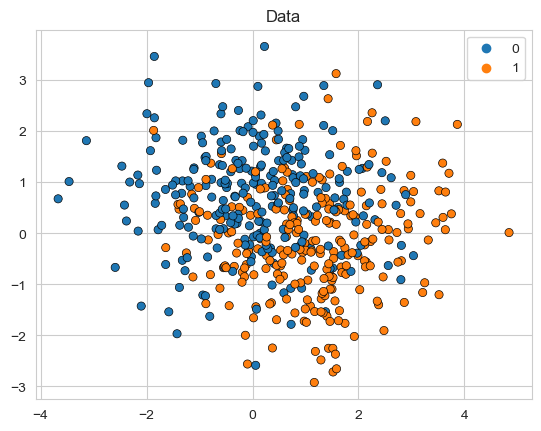

In [76]:
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=35, edgecolor="k", legend=True
).set_title("Data")

Vamos agora instanciar os modelos que usaremos para realizar a classificação.

Usamos então, o `VotingClassifier` para determinar qual melhor modelo.

In [5]:
rnf_clf = RandomForestClassifier(n_estimators=40, n_jobs=10)
svm_clf = SVC()
lgr_clf = LogisticRegression()

voting_clf = VotingClassifier(
    estimators=[("rnf", rnf_clf), ("svc", svm_clf), ("lf", lgr_clf)],
    voting="hard"
)

voting_clf.fit(X, y)

VotingClassifier(estimators=[('rnf',
                              RandomForestClassifier(n_estimators=40,
                                                     n_jobs=10)),
                             ('svc', SVC()), ('lf', LogisticRegression())])

Agora podemos avaliar os resultados dos modelos.

Podemos fazer isso em um loop `for`, como abaixo.

In [6]:
for clf in (rnf_clf, svm_clf, lgr_clf, voting_clf):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), clf.__class__.__name__))

Accuracy: 0.71 (+/- 0.04) [RandomForestClassifier]
Accuracy: 0.74 (+/- 0.04) [SVC]
Accuracy: 0.73 (+/- 0.02) [LogisticRegression]
Accuracy: 0.74 (+/- 0.03) [VotingClassifier]


# Atividade

Aproveitando as variações que você fez na hora de criar o dataset, faça testes com diferentes valores de n_samples e noises, monte uma tabela com os resultados e analise.

----
# Grid Search

Desde que começamos a estudar o sklearn, vimos diferentes modelos, e cada modelo possui um conjunto de hiperparâmetros que precisam ser ajustados para se ter o melhor resultado.

Por exemplo, quando estudamos SVM`s vimos dois hiperparâmetros que podemos mudar para realizar ajustes que julgarmos necessários: $C$ e o kernel.

Naquele momento, mudamos principalmente o $C$ com o objetivo de obtermos a melhor fronteira de classificação. Mas isto foi feito manualmente, o que é contra-producente.

Existe uma maneira de automatizarmos estes testes e obtermos o melhor conjunto de hiperparâmetros possível. Aqui estamos falando do **GridSearch**:

    O GridSearch é uma técnica de ajuste que tenta calcular os valores ótimos dos hiperparâmetros. É uma busca exaustiva que é realizada nos valores de parâmetros específicos de um modelo.

Vamos implementar o **GridSearch** em uma classificação.

In [66]:

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV


In [67]:

X, y = make_classification(n_samples=1000, random_state=42)

In [68]:
param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

In [69]:
base_estimator = RandomForestClassifier(random_state=42)


In [70]:
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X, y)

In [77]:
# Verificando qual o melhor modelo

model = sh.best_estimator_

In [78]:
model

RandomForestClassifier(max_depth=10, n_estimators=24, random_state=42)

In [73]:
model.predict_proba(X)

array([[9.64506173e-04, 9.99035494e-01],
       [9.74131782e-01, 2.58682180e-02],
       [9.98003992e-04, 9.99001996e-01],
       ...,
       [4.36291768e-02, 9.56370823e-01],
       [9.07986674e-01, 9.20133258e-02],
       [9.88667235e-01, 1.13327645e-02]])

# Atividade
Volte no notebook da aula passada e realize um GridSearch para o problema de classificação Iris com SVC